In [1]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# If you are using Google Collab you will need this cell
try:
    %tensorflow_version 2.x
except Exception:
    import os

    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

<IPython.core.display.Javascript object>

In [3]:
# Change the SETUP = True if this is your fist run
SETUP = False

<IPython.core.display.Javascript object>

In [4]:
if SETUP:
    !pip install -q -U toai
    !pip install -q -U nb_black
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons
    !pip install -q -U tensorflow_hub
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)

<IPython.core.display.Javascript object>

In [5]:
from toai.imports import *
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_addons as tfa

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>

In [6]:
BATCH_SIZE = 32
IMG_DIMS = (299, 299, 3)
AUTOTUNE = tf.data.experimental.AUTOTUNE

<IPython.core.display.Javascript object>

In [7]:
DATA_DIR = Path("data/stanford-cars-dataset")
TEMP_DIR = Path("temp/stanford-cars-dataset")

<IPython.core.display.Javascript object>

In [8]:
if SETUP:
    shutil.rmtree(str(DATA_DIR))
    shutil.rmtree(str(TEMP_DIR))
    DATA_DIR.mkdir(parents=True)
    TEMP_DIR.mkdir(parents=True)
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        dataset="jutrera/stanford-car-dataset-by-classes-folder",
        path=DATA_DIR,
        unzip=True,
    )
    shutil.move(str(DATA_DIR / "car_data/car_data/train"), DATA_DIR)
    shutil.move(str(DATA_DIR / "car_data/car_data/test"), DATA_DIR)

<IPython.core.display.Javascript object>

In [9]:
class DataBundle:
    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x = x
        self.y = y

    @classmethod
    def split(
        cls,
        data_bundle: "DataBundle",
        fracs: Sequence[float],
        random: Optional[bool] = True,
    ) -> Tuple["DataBundle", ...]:
        x = data_bundle.x
        y = data_bundle.y

        if random:
            random_indices = np.random.permutation(len(data_bundle))
            x = x[random_indices]
            y = y[random_indices]

        result = []
        current_index = 0
        for frac in fracs:
            dx = math.ceil(len(data_bundle) * frac)
            split_data_bundle = cls(
                x=x[current_index : current_index + dx],
                y=y[current_index : current_index + dx],
            )
            result.append(split_data_bundle)
            current_index += dx

        return tuple(result)

    def __len__(self) -> int:
        return len(self.y)

    def value_counts(self) -> Dict[str, int]:
        values, counts = np.unique(self.y, return_counts=True)
        return dict(zip(values.tolist(), counts.tolist()))

    def make_label_map(self) -> Dict[str, int]:
        return {value: key for key, value in enumerate(np.unique(self.y))}

    def apply_label_map(self, label_map: Dict[str, int]) -> None:
        self.y = np.vectorize(label_map.get)(self.y)

<IPython.core.display.Javascript object>

In [10]:
class ImageDataBundle(DataBundle):
    @classmethod
    def from_subfolders(cls, path: Union[Path, str]) -> "ImageDataBundle":
        path = Path(path)
        paths = []
        labels = []
        for label in os.listdir(path):
            for image_path in os.listdir(path / label):
                paths.append(str(path / label / image_path))
                labels.append(label)

        return cls(np.asarray(paths), np.asarray(labels))

    def to_dataset(self) -> tf.data.Dataset:
        return tf.data.Dataset.from_tensor_slices((self.x, self.y))

<IPython.core.display.Javascript object>

In [11]:
train_data = ImageDataBundle.from_subfolders(DATA_DIR / "train")

<IPython.core.display.Javascript object>

In [12]:
test_data = ImageDataBundle.from_subfolders(DATA_DIR / "test")

<IPython.core.display.Javascript object>

In [13]:
valid_data, test_data = ImageDataBundle.split(data_bundle=test_data, fracs=(0.5, 0.5))

<IPython.core.display.Javascript object>

In [14]:
label_map = train_data.make_label_map()

<IPython.core.display.Javascript object>

In [15]:
label_map

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

<IPython.core.display.Javascript object>

In [16]:
from toai.utils import save_file, load_file

<IPython.core.display.Javascript object>

In [17]:
save_file(label_map, TEMP_DIR / "label_map.pickle")

<IPython.core.display.Javascript object>

In [18]:
label_map = load_file(TEMP_DIR / "label_map.pickle")

<IPython.core.display.Javascript object>

In [19]:
label_map

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

<IPython.core.display.Javascript object>

In [20]:
train_data.apply_label_map(label_map)

<IPython.core.display.Javascript object>

In [21]:
valid_data.apply_label_map(label_map)

<IPython.core.display.Javascript object>

In [22]:
test_data.apply_label_map(label_map)

<IPython.core.display.Javascript object>

In [23]:
@attr.s(auto_attribs=True)
class ImageParser:
    n_channels: int = 3

    def __call__(self, filename: str, label: Any) -> tf.Tensor:
        image = tf.image.decode_jpeg(
            tf.io.read_file(filename), channels=self.n_channels
        )
        image = tf.image.convert_image_dtype(image, tf.float32)

        return image, label

<IPython.core.display.Javascript object>

In [24]:
@attr.s(auto_attribs=True)
class ImageResizer:
    img_dims: Tuple[int, int, int]
    resize: Optional[str] = None
    crop_adjustment: float = 1

    def __call__(self, image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        height, width, _ = self.img_dims
        if self.resize == "stretch":
            image = tf.image.resize(image, (height, width))
        elif self.resize == "crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(
                images=image, size=(crop_height, crop_width), preserve_aspect_ratio=True
            )
            image = tf.image.resize_with_crop_or_pad(image, height, width)
        elif self.resize == "random_crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(image, (crop_height, crop_width))
            image = tf.image.random_crop(image, self.img_dims)

        return image, label

<IPython.core.display.Javascript object>

In [25]:
@attr.s(auto_attribs=True)
class ImageAugmentor:
    level: int = 0
    flips: Optional[str] = None

    def __call__(self, image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        if self.flips in ["horizontal", "both"]:
            image = tf.image.random_flip_left_right(image)
        if self.flips in ["vertical", "both"]:
            image = tf.image.random_flip_up_down(image)

        if self.level > 0:
            lower = 1 - 0.1 * self.level
            upper = 1 + 0.1 * self.level
            min_jpeg_quality = max(0, int((lower - 0.5) * 100))
            max_jpeg_quality = min(100, int((upper - 0.5) * 100))
            image = tf.image.random_jpeg_quality(
                image,
                min_jpeg_quality=min_jpeg_quality,
                max_jpeg_quality=max_jpeg_quality,
            )
            image = tf.image.random_contrast(image, lower=lower, upper=upper)
            image = tf.image.random_saturation(image, lower=lower, upper=upper)
            image = tfa.image.rotate(image, tf.random.uniform((), lower - 1, upper - 1))
            image = tf.clip_by_value(image, 0.0, 1.0)
        return image, label

<IPython.core.display.Javascript object>

In [26]:
train_dataset = (
    train_data.to_dataset()
    .shuffle(len(train_data))
    .map(ImageParser(), num_parallel_calls=AUTOTUNE)
    .map(ImageResizer(img_dims=IMG_DIMS, resize="stretch"), num_parallel_calls=AUTOTUNE)
    .cache()
)

<IPython.core.display.Javascript object>

In [27]:
valid_dataset = (
    valid_data.to_dataset()
    .map(ImageParser(), num_parallel_calls=AUTOTUNE)
    .map(ImageResizer(img_dims=IMG_DIMS, resize="stretch"), num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

<IPython.core.display.Javascript object>

In [28]:
test_dataset = (
    test_data.to_dataset()
    .map(ImageParser(), num_parallel_calls=AUTOTUNE)
    .map(ImageResizer(img_dims=IMG_DIMS, resize="stretch"), num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

<IPython.core.display.Javascript object>

In [29]:
class DataContainer:
    def __init__(
        self,
        base: tf.data.Dataset,
        train: Optional[tf.data.Dataset] = None,
        train_steps: Optional[int] = None,
        validation: Optional[tf.data.Dataset] = None,
        validation_steps: Optional[int] = None,
        test: Optional[tf.data.Dataset] = None,
        test_steps: Optional[int] = None,
        label_map: Optional[Dict[str, int]] = None,
        n_classes: Optional[int] = None,
    ):
        self.base = base
        self.train = train
        self.train_steps = train_steps
        self.validation = validation
        self.validation_steps = validation_steps
        self.test = test
        self.test_steps = test_steps
        self.label_map = label_map
        if n_classes:
            self.n_classes = n_classes
        elif label_map:
            self.n_classes = len(label_map.keys())

    def show(self, mode: str, rows: int = 3, cols: int = 6, debug: bool = False):
        if debug and self.label_map:
            reverse_label_map = {value: key for key, value in self.label_map.items()}
        figsize = (4 * cols, 5 * rows) if debug else (3 * cols, 3 * rows)
        _, ax = plt.subplots(rows, cols, figsize=figsize)

        for i, (x, y) in enumerate(getattr(self, mode).unbatch().take(rows * cols)):
            x = x.numpy()
            y = y.numpy()
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(x)
            if debug and self.label_map:
                title = (
                    f"{reverse_label_map[y][:40]}\nLabel code: {y}\nShape: {x.shape}"
                )
            elif debug:
                title = f"Label code: {y}\nShape: {x.shape}"
            else:
                title = y
            ax[idx].set_title(title)

<IPython.core.display.Javascript object>

In [30]:
data_container = DataContainer(
    base=train_dataset,
    train=train_dataset.map(
        ImageAugmentor(level=2, flips="horizontal"), num_parallel_calls=AUTOTUNE
    )
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE),
    train_steps=math.ceil(len(train_data) / BATCH_SIZE),
    validation=valid_dataset,
    test=test_dataset,
    label_map=label_map,
)

<IPython.core.display.Javascript object>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


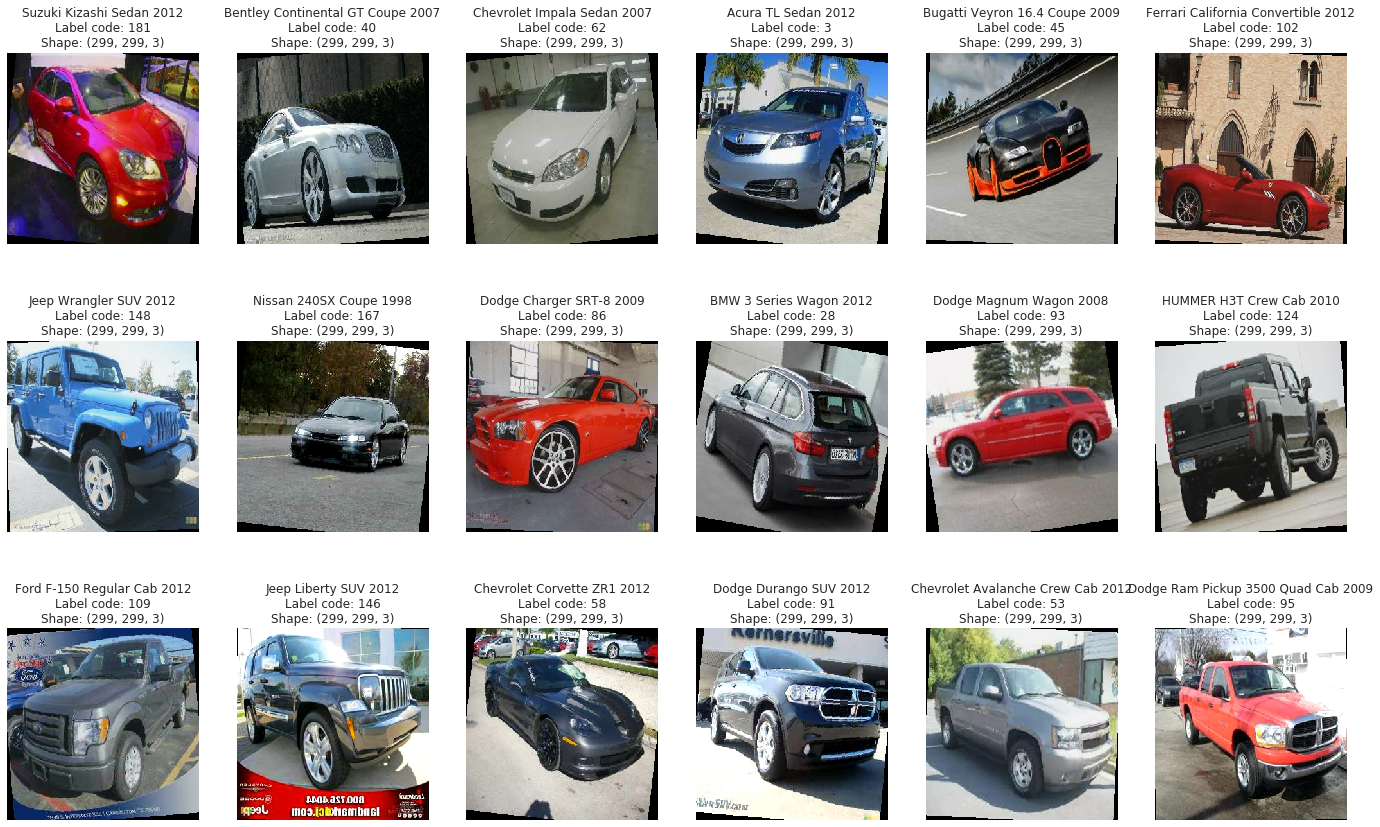

<IPython.core.display.Javascript object>

In [31]:
data_container.show("train", debug=True)

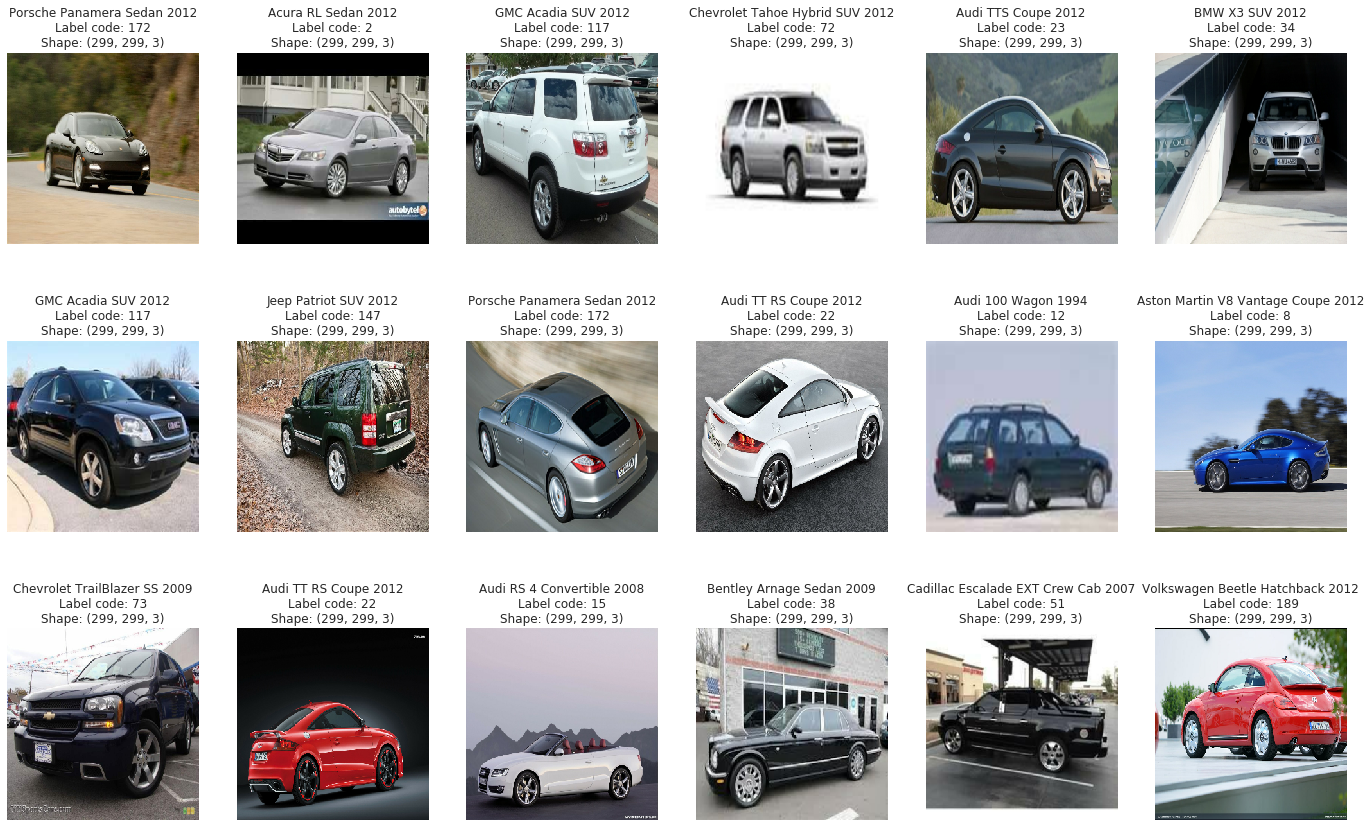

<IPython.core.display.Javascript object>

In [32]:
data_container.show("validation", debug=True)

In [49]:
class ImageLearner:
    def __init__(
        self,
        path: Union[Path, str],
        base_model: keras.Model,
        input_shape: Iterable[int],
        output_shape: Iterable[int],
        activation: Union[str, Callable],
        loss: Union[str, Callable],
        metrics: List[Callable],
        dropout: float = 0.0,
        l1: Optional[float] = None,
        l2: Optional[float] = None,
        override: bool = False,
        load: bool = False,
        class_weight: Optional[Dict[int, float]] = None,
        sample_weight: Optional[np.ndarray] = None,
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f"{self.path}/logs"

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.activation = activation
        self.loss = loss
        self.metrics = metrics
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2
        self.class_weight = class_weight
        self.sample_weight = sample_weight

        self.base_model = base_model(include_top=False, input_shape=input_shape)
        self.concat_layer = keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(self.base_model.output),
                keras.layers.GlobalMaxPool2D()(self.base_model.output),
            ]
        )
        self.bn_layer = keras.layers.BatchNormalization()(self.concat_layer)
        self.dropout_layer = keras.layers.Dropout(dropout)(self.bn_layer)

        if self.l1 is not None and self.l2 is not None:
            kernel_regularizer = keras.regularizers.l1_l2(self.l1, self.l2)
        elif self.l1 is None and self.l2 is not None:
            kernel_regularizer = keras.regularizers.l2(self.l2)
        elif self.l1 is not None and self.l2 is None:
            kernel_regularizer = keras.regularizers.l1(self.l1)
        else:
            kernel_regularizer = None

        self.output_layers = [
            keras.layers.Dense(
                output_size,
                kernel_regularizer=kernel_regularizer,
                activation=activation,
            )(self.dropout_layer)
            for output_size in self.output_shape
        ]

        self.model = keras.Model(
            inputs=self.base_model.inputs, outputs=self.output_layers
        )

        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)

        self.save()

    def save(self) -> None:
        save_keras_model(self.model, self.architecture_path, self.weights_path)

    def load(self, weights_only: bool = False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)

    def compile(self, optimizer: keras.optimizers.Optimizer, lr: float):
        self.model.compile(
            optimizer=optimizer(lr), loss=self.loss, metrics=self.metrics
        )

    def freeze(self, n_layers: int = 1):
        for layer in self.model.layers[:-n_layers]:
            layer.trainable = False

    def unfreeze(self):
        for layer in self.model.layers:
            layer.trainable = True

    def fit(
        self,
        epochs: int,
        train_dataset: tf.data.Dataset,
        train_dataset_steps: int,
        validation_dataset: tf.data.Dataset,
        validation_dataset_steps: Optional[int] = None,
        verbose: int = 1,
    ):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2

        self.history = self.model.fit(
            x=train_dataset,
            steps_per_epoch=train_dataset_steps,
            validation_data=validation_dataset,
            validation_steps=validation_dataset_steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True
                ),
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True
                ),
            ],
            verbose=verbose,
            class_weight=self.class_weight,
            sample_weight=self.sample_weight,
        )
        self.load(weights_only=True)

    def predict(
        self,
        pipeline: List[Callable],
        image_paths: Optional[Iterable[str]] = None,
        images: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        if images is None:
            images = tf.data.Dataset.from_tensor_slices(image_paths)
        for fun in pipeline:
            images = images.map(fun, num_parallel_calls=1)
        images = images.batch(1)
        return self.model.predict(images)

    def show_history(self, contains: str, skip: int = 0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()

<IPython.core.display.Javascript object>

In [50]:
from toai.metrics import sparse_top_2_categorical_accuracy

<IPython.core.display.Javascript object>

In [51]:
from toai.models import save_keras_model, load_keras_model

<IPython.core.display.Javascript object>

In [52]:
learner = ImageLearner(
    path=TEMP_DIR / "xception_v3",
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    output_shape=[data_container.n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
    dropout=0.5,
    l1=3e-5,
    l2=3e-4,
    override=True,
)

<IPython.core.display.Javascript object>

In [53]:
learner.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [54]:
@attr.s(auto_attribs=True)
class ImageTrainingCycle:
    data: tf.data.Dataset
    steps: int
    n_epochs: int
    lr: float
    optimizer: keras.optimizers.Optimizer
    freeze: bool = False

<IPython.core.display.Javascript object>

In [55]:
@attr.s(auto_attribs=True)
class ImageTrainer:
    learner: ImageLearner
    data_container: DataContainer

    def train(
        self,
        cycles: Iterable[ImageTrainingCycle],
        template: str = (
            "Name: {} Train Time: {:.1f} min. "
            "Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}"
        ),
    ):
        start_time = time.time()
        for cycle in cycles:
            self.learner.freeze() if cycle.freeze else self.learner.unfreeze()
            self.learner.compile(optimizer=cycle.optimizer, lr=cycle.lr)
            self.learner.fit(
                cycle.n_epochs,
                cycle.data,
                cycle.steps,
                self.data_container.validation,
                self.data_container.validation_steps,
            )
        end_time = time.time()

        eval_start_time = time.time()
        evaluation_results = self.evaluate(
            self.data_container.validation,
            self.data_container.validation_steps,
            verbose=0,
        )
        eval_end_time = time.time()

        print("-".center(80, "-"))
        print(
            template.format(
                self.learner.base_model.name,
                (end_time - start_time) / 60,
                (eval_end_time - eval_start_time),
                *evaluation_results,
            )
        )
        print("-".center(80, "-"))

    def evaluate(
        self, dataset: tf.data.Dataset, steps: Optional[int] = None, verbose: int = 1
    ):
        return self.learner.model.evaluate(dataset, steps=steps, verbose=verbose)

    def predict(
        self, dataset: tf.data.Dataset, steps: Optional[int] = None, verbose: int = 0
    ):
        return self.learner.model.predict(dataset, steps=steps, verbose=verbose)

    def report(
        self, dataset: tf.data.Dataset, steps: Optional[int] = None, verbose: int = 0
    ):
        return classification_report(
            [label.numpy() for _, label in dataset.take(steps).unbatch()],
            self.learner.model.predict(dataset, steps=steps).argmax(axis=1),
        )

    def analyse(
        self, dataset: tf.data.Dataset, steps: Optional[int] = None, verbose: int = 0
    ):
        reverse_label_map = {
            value: key for key, value in self.data_container.label_map.items()
        }
        images = []
        label_codes = []
        for image, label_code in dataset.take(steps).unbatch():
            label_codes.append(label_code.numpy())
            images.append(image.numpy())
        labels = [reverse_label_map[label_code] for label_code in label_codes]
        probs = self.learner.model.predict(dataset, steps=steps)
        pred_codes = probs.argmax(axis=1)
        preds = [reverse_label_map[pred_code] for pred_code in pred_codes]
        return pd.DataFrame.from_dict(
            {
                "image": images,
                "label": labels,
                "label_code": label_codes,
                "pred": preds,
                "pred_code": pred_codes,
                "label_probs": probs[:, label_codes][np.eye(len(labels), dtype=bool)],
                "pred_probs": probs[:, pred_codes][np.eye(len(pred_codes), dtype=bool)],
            }
        )

    def show_predictions(
        self,
        dataset: tf.data.Dataset,
        steps: int,
        correct: bool = False,
        ascending: bool = True,
        rows: int = 4,
        cols: int = 4,
    ):
        df = self.analyse(dataset=dataset, steps=steps)
        df = df[(df.label == df.pred) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plt.subplots(rows, cols, figsize=(4 * cols, 5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(
                f"{row.label}\n{row.pred}\n{row.label_probs:.4f}\n{row.pred_probs:.4f}"
            )

<IPython.core.display.Javascript object>

In [56]:
trainer = ImageTrainer(learner=learner, data_container=data_container)

<IPython.core.display.Javascript object>

In [57]:
data_container.validation_steps

<IPython.core.display.Javascript object>

In [58]:
from toai.image import LearningRateFinder

<IPython.core.display.Javascript object>

In [59]:
learner.compile(keras.optimizers.Adam, 1e-4)

<IPython.core.display.Javascript object>

In [60]:
lr_finder = LearningRateFinder(learner.model)

<IPython.core.display.Javascript object>

In [61]:
lr_finder.find(data_container.train, start_lr=1e-6, end_lr=1e-3, epochs=50)

<IPython.core.display.Javascript object>

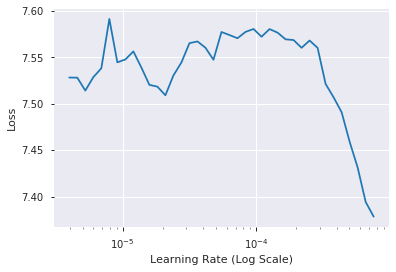

<IPython.core.display.Javascript object>

In [62]:
lr_finder.plot_loss()

In [63]:
cycles = [
    ImageTrainingCycle(
        data=data_container.base.map(
            ImageAugmentor(level=1, flips="horizontal"), num_parallel_calls=AUTOTUNE
        )
        .repeat()
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE),
        steps=data_container.train_steps,
        n_epochs=6,
        lr=3e-4,
        optimizer=keras.optimizers.Adam,
        freeze=True,
    ),
    ImageTrainingCycle(
        data=data_container.base.map(
            ImageAugmentor(level=5, flips="horizontal"), num_parallel_calls=AUTOTUNE
        )
        .repeat()
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE),
        steps=data_container.train_steps,
        n_epochs=6,
        lr=1e-4,
        optimizer=keras.optimizers.Adam,
    ),
    ImageTrainingCycle(
        data=data_container.base.map(
            ImageAugmentor(level=4, flips="horizontal"), num_parallel_calls=AUTOTUNE
        )
        .repeat()
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE),
        steps=data_container.train_steps,
        n_epochs=12,
        lr=3e-5,
        optimizer=keras.optimizers.Adam,
    ),
    ImageTrainingCycle(
        data=data_container.base.map(
            ImageAugmentor(level=3, flips="horizontal"), num_parallel_calls=AUTOTUNE
        )
        .repeat()
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE),
        steps=data_container.train_steps,
        n_epochs=12,
        lr=3e-5,
        optimizer=keras.optimizers.Adam,
    ),
]

<IPython.core.display.Javascript object>

In [64]:
trainer.train(cycles=cycles)

Train for 255 steps, validate for 126 steps
Epoch 1/6
255/255 [==============================] - 48s 187ms/step - loss: 6.9109 - sparse_categorical_accuracy: 0.0305 - sparse_top_2_categorical_accuracy: 0.0512 - val_loss: 4.9956 - val_sparse_categorical_accuracy: 0.0634 - val_sparse_top_2_categorical_accuracy: 0.1087
Epoch 2/6
255/255 [==============================] - 40s 158ms/step - loss: 5.4983 - sparse_categorical_accuracy: 0.0888 - sparse_top_2_categorical_accuracy: 0.1400 - val_loss: 4.7637 - val_sparse_categorical_accuracy: 0.0793 - val_sparse_top_2_categorical_accuracy: 0.1430
Epoch 3/6
255/255 [==============================] - 40s 156ms/step - loss: 4.8812 - sparse_categorical_accuracy: 0.1382 - sparse_top_2_categorical_accuracy: 0.2154 - val_loss: 4.6282 - val_sparse_categorical_accuracy: 0.0972 - val_sparse_top_2_categorical_accuracy: 0.1709
Epoch 4/6
255/255 [==============================] - 40s 158ms/step - loss: 4.4724 - sparse_categorical_accuracy: 0.1784 - sparse_top_

<IPython.core.display.Javascript object>

In [65]:
trainer.train(
    cycles=[
        ImageTrainingCycle(
            data=data_container.base.map(
                ImageAugmentor(level=4, flips="horizontal"), num_parallel_calls=AUTOTUNE
            )
            .repeat()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE),
            steps=data_container.train_steps // 10,
            n_epochs=50,
            lr=1e-4,
            optimizer=keras.optimizers.Adam,
        )
    ]
)

Train for 25 steps, validate for 126 steps
Epoch 1/50
25/25 [==============================] - 30s 1s/step - loss: 0.3315 - sparse_categorical_accuracy: 0.9975 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.9740 - val_sparse_categorical_accuracy: 0.8197 - val_sparse_top_2_categorical_accuracy: 0.9050
Epoch 2/50
25/25 [==============================] - 23s 931ms/step - loss: 0.3355 - sparse_categorical_accuracy: 0.9950 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.9922 - val_sparse_categorical_accuracy: 0.8165 - val_sparse_top_2_categorical_accuracy: 0.8993
Epoch 3/50
25/25 [==============================] - 23s 931ms/step - loss: 0.3323 - sparse_categorical_accuracy: 0.9950 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 1.0173 - val_sparse_categorical_accuracy: 0.8100 - val_sparse_top_2_categorical_accuracy: 0.8953
Epoch 4/50
25/25 [==============================] - 23s 933ms/step - loss: 0.3349 - sparse_categorical_accuracy: 0.9875 - sparse_top_2_catego

Epoch 31/50
25/25 [==============================] - 24s 949ms/step - loss: 0.2922 - sparse_categorical_accuracy: 0.9987 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.8793 - val_sparse_categorical_accuracy: 0.8433 - val_sparse_top_2_categorical_accuracy: 0.9167
Epoch 32/50
25/25 [==============================] - 24s 947ms/step - loss: 0.3000 - sparse_categorical_accuracy: 0.9937 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.8711 - val_sparse_categorical_accuracy: 0.8431 - val_sparse_top_2_categorical_accuracy: 0.9174
Epoch 33/50
25/25 [==============================] - 24s 949ms/step - loss: 0.2827 - sparse_categorical_accuracy: 0.9987 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.8704 - val_sparse_categorical_accuracy: 0.8456 - val_sparse_top_2_categorical_accuracy: 0.9164
Epoch 34/50
25/25 [==============================] - 24s 948ms/step - loss: 0.2874 - sparse_categorical_accuracy: 0.9975 - sparse_top_2_categorical_accuracy: 0.9987 - val_loss: 0

<IPython.core.display.Javascript object>

In [66]:
print(
    classification_report(
        [label.numpy() for _, label in data_container.validation.unbatch()],
        learner.model.predict(data_container.validation).argmax(axis=1),
    )
)

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.88      1.00      0.94        23
           2       0.59      0.93      0.72        14
           3       0.91      0.91      0.91        23
           4       1.00      0.93      0.96        27
           5       0.93      0.76      0.84        17
           6       0.84      0.84      0.84        19
           7       0.68      0.75      0.71        28
           8       0.79      0.65      0.71        23
           9       0.90      0.69      0.78        13
          10       0.82      0.86      0.84        21
          11       0.62      0.68      0.65        19
          12       0.76      0.81      0.79        16
          13       0.73      0.80      0.76        20
          14       0.90      0.86      0.88        21
          15       0.83      0.87      0.85        23
          16       0.91      0.95      0.93        21
          17       0.83    

<IPython.core.display.Javascript object>

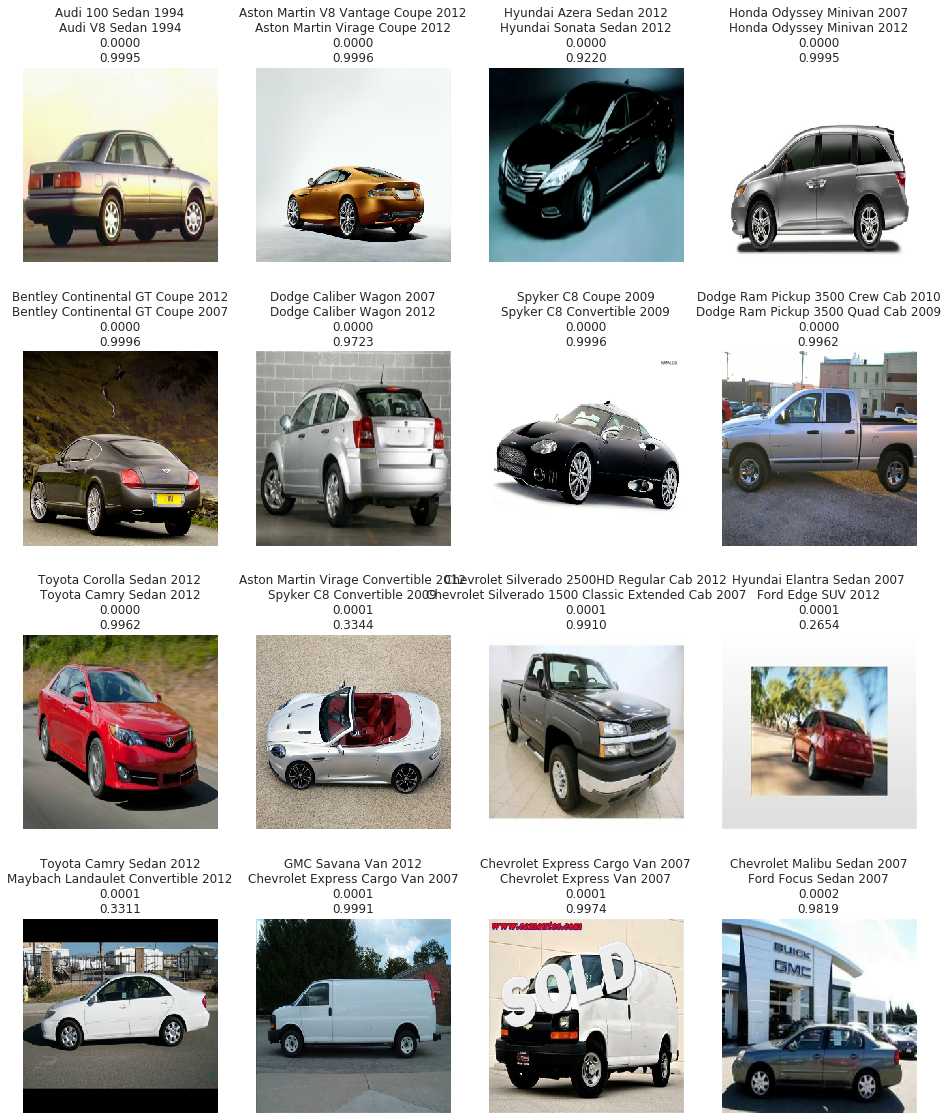

<IPython.core.display.Javascript object>

In [72]:
trainer.show_predictions(data_container.validation, steps=len(valid_data) // BATCH_SIZE)

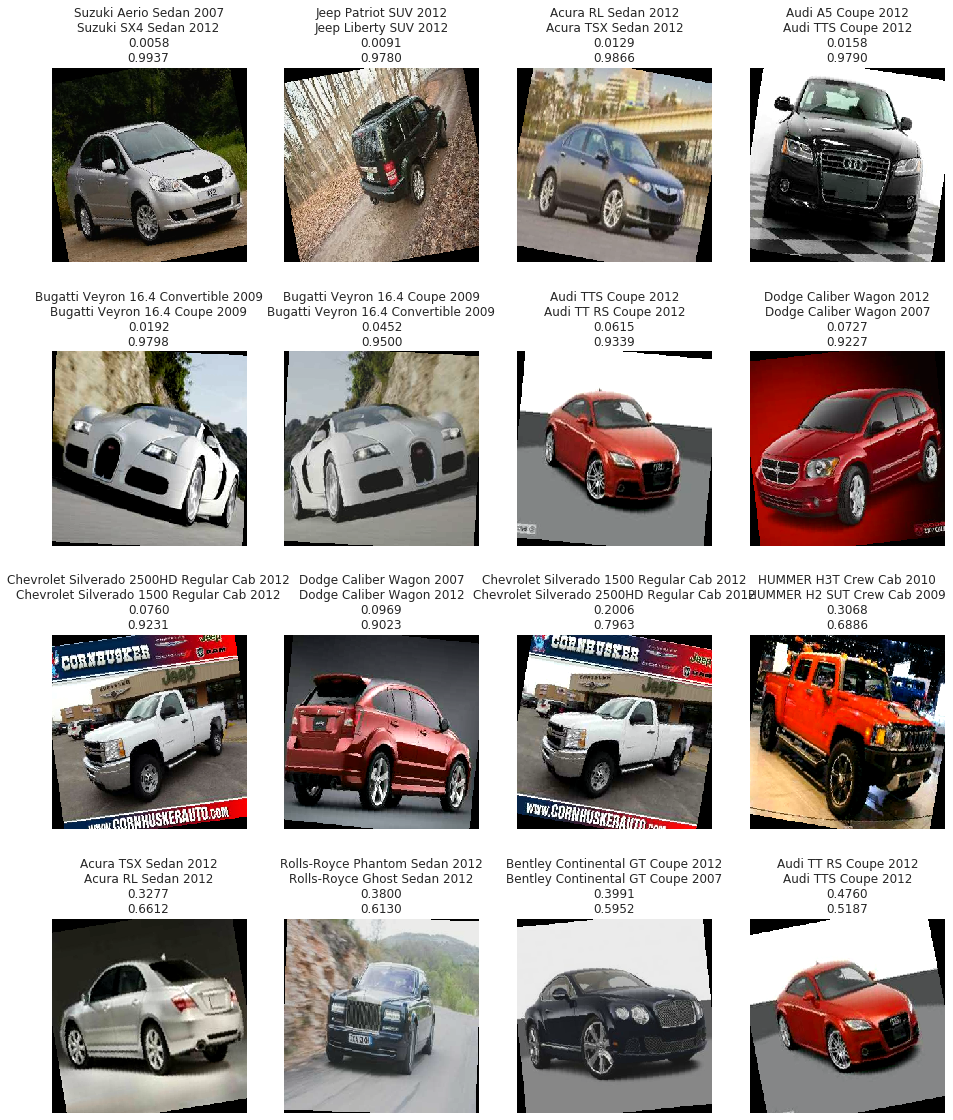

<IPython.core.display.Javascript object>

In [73]:
trainer.show_predictions(data_container.train, steps=data_container.train_steps)